Rethinking the Inception Architecture for Computer Vision

Christian Szegedy, Vincent Vanhoucke, Sergey Ioffe, Jonathon Shlens, Zbigniew Wojna

http://arxiv.org/abs/1512.00567


## 미리 학습된 모델들

인공신경망은 파라미터가 많을 수록 최고로 잘 동작하며 강력한 function approximator가 된다. 하지만 이건 아주 큰 데이터셋으로 학습되어야 한다는 걸 의미한다. 밑바닥부터 모델을 학습하는 것은 computationally intensive한 과정이기 때문에 며칠 혹은 몇 주의 시간이 요구되기 때문에, 아래에 사전에 학습된 모델을 제공한다. 이 CNN들은 이미지넷 2012 데이터셋으로 학습되었다.

## 모델을 학습하기 위해 실질적으로 고려할 점

모델 구조와 훈련과정은 모델을 학습시키는데 사용되는 하드웨어에 크게 의존한다. 만약 당신의 컴퓨터에서 이 모델을 훈련시키거나 fine-tune하려 한다면 셋팅에 맞춰서 좋은 훈련용 hyper-parameter를 조정해서 경험적으로 선택해야 한다. 다음 언급되는 것들은 일반적으로 고려되는 것들이다.

### 좋은 hyperparmeter 찾기

대략 5~10개의 hyper-parameter가 네트워크를 학습시키는 속도에 영향을 미친다. `--batch_size`와 `--num_gpus`와 함께, 학습 과정에 영향을 주는 값들이 inception_train.py에 정의되어 있다.

```python
RMSPROP_DECAY = 0.9                # Decay term for RMSProp.
MOMENTUM = 0.9                     # Momentum in RMSProp.
RMSPROP_EPSILON = 1.0              # Epsilon term for RMSProp.
INITIAL_LEARNING_RATE = 0.1        # Initial learning rate.
NUM_EPOCHS_PER_DECAY = 30.0        # Epochs after which learning rate decays.
LEARNING_RATE_DECAY_FACTOR = 0.16  # Learning rate decay factor.
```

stochastic gradient descent로 학습시키는것과 관련하여 다양한 트릭과 trade-offs에 대해 논의하는 논문들이 많이 있다. 참고할만한 훌륭한 자료는

- Practical recommendations for gradient-based training of deep architectures
- http://www.deeplearningbook.org

다음은 특정한 모델 학습 셋업과 관련해 적절한 hyper-parameter를 찾는데 일반적인 조언들을 정리한 것이다. 즉, 이 라이브러리는 다중 GPU 환경에서 batch-splitting에 기반하여 모델의 파라미터들을 동기식 업데이트를 제공한다. 

- 높은 learning rates는 학습을 빠르게 한다. 너무 높은 learning rate는 학습을 불안정하게 하고 모델 파라미터가 무한이나 Nan으로 발산하게 한다.

- 큰 배치 사이즈는 gradient의 예측값을 더 뛰어나게 해주고 높은 learning rate으로 모델을 학습하도록 해준다.

- 종종 GPU 메모리가 큰 배치 사이즈로 학습하는 것을 방해하는 제약사항이 된다. 더 많은 GPU를 돌리는 것은 GPU별로 배치를 분할하기 때문에 더 큰 배치사이즈로 돌릴 수 있게 한다.


## 밑바닥부터 학습하기

- 각 GPU에 개별적인 모델 복사본을 놓는다
- GPU별로 배치를 분할한다
- 모든 GPU가 배치단위 데이터의 처리가 끝날때 까지 기다리고 동시에 모델 파라미터를 업데이트한다
 

# Slim

```python
with tf.variable_scope(scope, 'InceptionV3', [inputs]):
    with slim.arg_scope([slim.conv2d, slim.max_pool2d, slim.avg_pool2d],
                        stride=1, padding='VALID'):
      # 299 x 299 x 3
      end_point = 'Conv2d_1a_3x3'
      net = slim.conv2d(inputs, depth(32), [3, 3], stride=2, scope=end_point)
      end_points[end_point] = net
      if end_point == final_endpoint: return net, end_points
      # 149 x 149 x 32
      end_point = 'Conv2d_2a_3x3'
      net = slim.conv2d(net, depth(32), [3, 3], scope=end_point)
      end_points[end_point] = net
      if end_point == final_endpoint: return net, end_points
      # 147 x 147 x 32
      end_point = 'Conv2d_2b_3x3'
      net = slim.conv2d(net, depth(64), [3, 3], padding='SAME', scope=end_point)
      end_points[end_point] = net
      if end_point == final_endpoint: return net, end_points
      # 147 x 147 x 64
      end_point = 'MaxPool_3a_3x3'
      net = slim.max_pool2d(net, [3, 3], stride=2, scope=end_point)
      end_points[end_point] = net
      if end_point == final_endpoint: return net, end_points
      # 73 x 73 x 64
      end_point = 'Conv2d_3b_1x1'
      net = slim.conv2d(net, depth(80), [1, 1], scope=end_point)
      end_points[end_point] = net
      if end_point == final_endpoint: return net, end_points
      # 73 x 73 x 80.
      end_point = 'Conv2d_4a_3x3'
      net = slim.conv2d(net, depth(192), [3, 3], scope=end_point)
      end_points[end_point] = net
      if end_point == final_endpoint: return net, end_points
      # 71 x 71 x 192.
      end_point = 'MaxPool_5a_3x3'
      net = slim.max_pool2d(net, [3, 3], stride=2, scope=end_point)
      end_points[end_point] = net
      if end_point == final_endpoint: return net, end_points
      # 35 x 35 x 192.
        
```

```python
# Inception blocks
    with slim.arg_scope([slim.conv2d, slim.max_pool2d, slim.avg_pool2d],
                        stride=1, padding='SAME'):
      # mixed: 35 x 35 x 256.
      end_point = 'Mixed_5b'
      with tf.variable_scope(end_point):
        with tf.variable_scope('Branch_0'):
          branch_0 = slim.conv2d(net, depth(64), [1, 1], scope='Conv2d_0a_1x1')
        with tf.variable_scope('Branch_1'):
          branch_1 = slim.conv2d(net, depth(48), [1, 1], scope='Conv2d_0a_1x1')
          branch_1 = slim.conv2d(branch_1, depth(64), [5, 5],
                                 scope='Conv2d_0b_5x5')
        with tf.variable_scope('Branch_2'):
          branch_2 = slim.conv2d(net, depth(64), [1, 1], scope='Conv2d_0a_1x1')
          branch_2 = slim.conv2d(branch_2, depth(96), [3, 3],
                                 scope='Conv2d_0b_3x3')
          branch_2 = slim.conv2d(branch_2, depth(96), [3, 3],
                                 scope='Conv2d_0c_3x3')
        with tf.variable_scope('Branch_3'):
          branch_3 = slim.avg_pool2d(net, [3, 3], scope='AvgPool_0a_3x3')
          branch_3 = slim.conv2d(branch_3, depth(32), [1, 1],
                                 scope='Conv2d_0b_1x1')
        net = tf.concat(axis=3, values=[branch_0, branch_1, branch_2, branch_3])
      end_points[end_point] = net
      if end_point == final_endpoint: return net, end_points
```

http://gusrb.tistory.com/20

https://hackaday.io/project/20448-elephant-ai/log/56896-retraining-tensorflow-inception-v3-using-tensorflow-slim-part-1

http://roadcom.tistory.com/37

http://gusrb.tistory.com/54

https://github.com/tensorflow/models/tree/master/research/slim

## 처음부터 모델 학습시키기

어떠한 TF-Slim 데이터셋을 쓰더라도 처음부터 모델을 학습시킬 수 있는 간단한 방법을 제공한다. 다음 예제는 어떻게 이미지넷 데이터셋에 대한 기본 파라미터값으로 Inception V3을 학습시키는지 보여준다.

```python
DATASET_DIR=/tmp/imagenet
TRAIN_DIR=/tmp/train_logs
python train_image_classifier.py \
    --train_dir=TRAIN_DIR \
    --dataset_name=imagenet \
    --dataset_split_name=train \
    --dataset_dir=DATASET_DIR \
    --model_name=inception_v3

```

이 과정은 하드웨어에 따라서 며칠이 걸릴 수도 있다. 편의를 위해 다중 GPU나 다중 CPU에서 그리고 동기식으로 혹은 비동기식으로 모델을 학습시키는 방법을 제공한다.

### 텐서보드

학습 중에 loss와 다른 metric이 시각화되는 것을 보기 위해선 텐서보드를 이용한다.


## 체크포인트로 부터 모델을 Fine-Tuning시키기

우린 종종 처음부터 학습시키기 보단 미리 학습된 모델에서 시작해서 fine-tune시키기 원한다. fine-tune하기 위해 어디에 체크포인트가 있는지 가리키기 위해 `--checkpoint_path` 플래그와 함께 학습을 하게 하는데 체크포인트 파일이 있는 절대경로를 할당한다.

모델을 fine-tuning할 때에, 우리는 체크포인트 weight를 가져올 때 조심해야한다. 특히 output label의 수가 다른 새로운 작업에 대해 모델을 fine-tune시킬 때, 마지막 classifier 레이어를 가져오지 못할 것이다. 이를 위해서 `--checkpoint_exclude_scopes` 플래그를 사용한다. 이 플래그는 특정한 변수가 로딩되는 것을 막는다. 학습된 모델과 다른 수의 class를 사용하여 classification 작업에 fine-tune하면 새로운 모델을 최종 logits 레이어의 차원이 미리 학습된 모델과 다를 것이다. 예를 들어 이미지넷으로 학습한 모델을 꽃 데이터에 fine-tuning시킨다면, 미리 학습된 logits layer는 2048x1001 차원을 지니지만 새로운 logit 레이어는 2048x5를 가질 것이다. 따라서, 이 플래그는 체크포인트에 있는 이런 weight가 로딩되는 것을 막도록 해준다.

체크포인트에서 천천히 시작하는 것은 모델의 초기화중에만 모델의 weight에 영향을 준다. 일단 모델이 학습을 시작하면, 새로운 체크포인트가 새로운 체크포인트가 `TRAIN_DIR`에 만들어진다. 만약 fine-tuning 학습이 중단되었다가 다시 시작되면 새로운 체크포인트에 weight가 저장된다(`checkpint_path` 가 아니라)

따라서 `--checkpoint_path`와 `--checkpoint_exclude_scopes`는 오직 0번째 global step(모델 초기화순간)에만 사용된다. 보통 fine-tune을 위해서 레이어 일부분만 학습시키기 원하므로 `--trainable_scopes`플래그는 어떤 레이어만 일부 학습할지 나타내고 나머지는 고정된다.

아래 예제는 1000개 class가 있는 이미지넷으로 학습된 inception_v3를 fine-tuning하는 것이다. 꽃 데이터셋에는 오직 5개의 class만 있다. 데이터셋이 작기때문에 새로운 레이어만 학습하도록 한다.

In [3]:
%run train_image_classifier.py ^
--train_dir = TRAINDIR ^
--dataset_name=flowers ^
--dataset_split_name=train ^
--dataset_dir=DATASET ^
--model_name=inception_v3 ^
--checkpoint_path=PRETRAINEDCHECKPOINTDIR/inception_v3.ckpt ^
--checkpoint_exclude_scopes=InceptionV3/Logits,InceptionV3/AuxLogits ^
--trainable_scopes=InceptionV3/Logits,InceptionV3/AuxLogits ^
--max_number_of_steps=1000 ^
--batch_size=32 ^
--learning_rate=0.01 ^
--learning_rate_decay_type=fixed ^
--save_interval_secs=60  ^
--save_summaries_secs=60 ^
--log_every_n_steps=100 ^
--optimizer=rmsprop ^
--weight_decay=0.00004

SyntaxError: invalid syntax (<ipython-input-3-27e9e062afcd>, line 2)

In [1]:
%run train_image_classifier.py --train_dir=TRAINDIR --dataset_dir=DATASET --dataset_name=flowers --dataset_split_name=train --model_name=inception_v3 --checkpoint_path=PRETRAINEDCHECKPOINTDIR/inception_v3.ckpt --checkpoint_exclude_scopes=InceptionV3/Logits,InceptionV3/AuxLogits --trainable_scopes=InceptionV3/Logits,InceptionV3/AuxLogits --max_number_of_steps=1000 --batch_size=20 --learning_rate=0.01 --learning_rate_decay_type=fixed --save_interval_secs=60  --save_summaries_secs=60 --log_every_n_steps=100 --optimizer=rmsprop --weight_decay=0.00004

Instructions for updating:
Use the retry module or similar alternatives.
Instructions for updating:
Please switch to tf.train.create_global_step
Instructions for updating:
Use tf.losses.softmax_cross_entropy instead. Note that the order of the logits and labels arguments has been changed.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.

Instructions for updating:
Use tf.losses.compute_weighted_loss instead.
Instructions for updating:
Use tf.losses.add_loss instead.
INFO:tensorflow:Fine-tuning from PRETRAINEDCHECKPOINTDIR/inception_v3.ckpt
Instructions for updating:
Please switch to tf.train.MonitoredTrainingSession
INFO:tensorflow:Restoring parameters from PRETRAINEDCHECKPOINTDIR/inception_v3.ckpt
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Starting Session.
INFO:tensorflow:Saving checkpoint to

## 평가하기

모델의 성능을 평가하기 위해 eval_image_classifier.py 스크립트를 사용할 수 있다.

미리 학습한 inception 모델에 이미지넷 데이터셋으로 평가하는 예제는 아래와 같다.

```
python eval_image_classifier.py \
    --alsologtostderr \
    --checkpoint_path={CHECKPOINT_FILE} \
    --dataset_dir={DATASET_DIR} \
    --dataset_name=imagenet \
    --dataset_split_name=validation \
    --model_name=inception_v3 \
    --batch_size=16
```

In [1]:
%run eval_image_classifier.py --checkpoint_path=TRAINDIR --eval_dir=TRAINDIR --dataset_name=flowers --dataset_split_name=validation --dataset_dir=DATASET --model_name=inception_v3 #--batch_size=20

Instructions for updating:
Use the retry module or similar alternatives.
Instructions for updating:
Please switch to tf.train.get_or_create_global_step
INFO:tensorflow:Scale of 0 disables regularizer.
Instructions for updating:
Please switch to tf.metrics.accuracy. Note that the order of the labels and predictions arguments has been switched.
Instructions for updating:
Please use `streaming_sparse_recall_at_k`, and reshape labels from [batch_size] to [batch_size, 1].
INFO:tensorflow:Evaluating TRAINDIR\model.ckpt-1000
INFO:tensorflow:Starting evaluation at 2018-07-27-18:19:54
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from TRAINDIR\model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1/4]
INFO:tensorflow:Evaluation [2/4]
INFO:tensorflow:Evaluation [3/4]
INFO:tensorflow:Evaluation [4/4]
INFO:tensorflow:Finished evaluation at 2018-07-27-18:20:02


In [ ]:
%run eval_image_classifier.py ^
--checkpoint_path=TRAINDIR ^
--eval_dir=TRAINDIR ^
--dataset_name=flowers ^
--dataset_split_name=validation ^
--dataset_dir=DATASET ^
--model_name=inception_v3

## 이미지에 미리학습된 모델 적용하기

INFO:tensorflow:Restoring parameters from PRETRAINEDCHECKPOINTDIR\inception_v3.ckpt


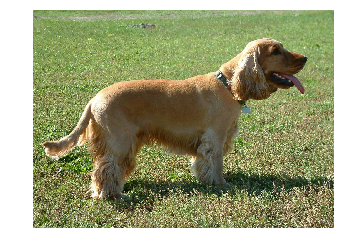

Probability 78.64% => [cocker spaniel, English cocker spaniel, cocker]
Probability 5.22% => [Sussex spaniel]
Probability 2.71% => [clumber, clumber spaniel]
Probability 0.54% => [golden retriever]
Probability 0.26% => [Irish setter, red setter]


In [2]:
import numpy as np
import os
import tensorflow as tf

try:
    import urllib2 as urllib
except ImportError:
    import urllib.request as urllib

from datasets import imagenet
from nets import inception
from preprocessing import inception_preprocessing
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from tensorflow.contrib import slim

checkpoints_dir = 'PRETRAINEDCHECKPOINTDIR'
image_size = inception.inception_v3.default_image_size

with tf.Graph().as_default():
    url = 'https://upload.wikimedia.org/wikipedia/commons/7/70/EnglishCockerSpaniel_simon.jpg'
    image_string = urllib.urlopen(url).read()
    image = tf.image.decode_jpeg(image_string, channels=3)
    processed_image = inception_preprocessing.preprocess_image(image, image_size, image_size, is_training=False)
    processed_images  = tf.expand_dims(processed_image, 0)
    
    # Create the model, use the default arg scope to configure the batch norm parameters.
    with slim.arg_scope(inception.inception_v3_arg_scope()):
        logits, _ = inception.inception_v3(processed_images, num_classes=1001, is_training=False)
    probabilities = tf.nn.softmax(logits)
    
    init_fn = slim.assign_from_checkpoint_fn(
        os.path.join(checkpoints_dir, 'inception_v3.ckpt'),
        slim.get_model_variables('InceptionV3'))
    
    with tf.Session() as sess:
        init_fn(sess)
        np_image, probabilities = sess.run([image, probabilities])
        probabilities = probabilities[0, 0:]
        sorted_inds = [i[0] for i in sorted(enumerate(-probabilities), key=lambda x:x[1])]
        
    plt.figure()
    plt.imshow(np_image.astype(np.uint8))
    plt.axis('off')
    plt.show()

    names = imagenet.create_readable_names_for_imagenet_labels()
    for i in range(5):
        index = sorted_inds[i]
        print('Probability %0.2f%% => [%s]' % (probabilities[index] * 100, names[index]))

In [ ]:
import numpy as np
import tensorflow as tf
from datasets import flowers
from nets import inception

from tensorflow.contrib import slim
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
from preprocessing import inception_preprocessing

def load_batch(dataset, batch_size=32, height=299, width=299, is_training=False):
    """Loads a single batch of data.
    
    Args:
      dataset: The dataset to load.
      batch_size: The number of images in the batch.
      height: The size of each image after preprocessing.
      width: The size of each image after preprocessing.
      is_training: Whether or not we're currently training or evaluating.
    
    Returns:
      images: A Tensor of size [batch_size, height, width, 3], image samples that have been preprocessed.
      images_raw: A Tensor of size [batch_size, height, width, 3], image samples that can be used for visualization.
      labels: A Tensor of size [batch_size], whose values range between 0 and dataset.num_classes.
    """
    data_provider = slim.dataset_data_provider.DatasetDataProvider(
        dataset, common_queue_capacity=32,
        common_queue_min=8)
    image_raw, label = data_provider.get(['image', 'label'])
    
    # Preprocess image for usage by Inception.
    image = inception_preprocessing.preprocess_image(image_raw, height, width, is_training=is_training)
    
    # Preprocess the image for display purposes.
    image_raw = tf.expand_dims(image_raw, 0)
    image_raw = tf.image.resize_images(image_raw, [height, width])
    image_raw = tf.squeeze(image_raw)

    # Batch it up.
    images, images_raw, labels = tf.train.batch(
          [image, image_raw, label],
          batch_size=batch_size,
          num_threads=1,
          capacity=2 * batch_size)
    
    return images, images_raw, labels

In [ ]:
flowers_data_dir = '/DATASET/'
image_size = inception.inception_v3.default_image_size
batch_size = 3

with tf.Graph().as_default():
    tf.logging.set_verbosity(tf.logging.INFO)
    
    dataset = flowers.get_split('train', flowers_data_dir)
    print('aa11')
    images, images_raw, labels = load_batch(dataset, height=image_size, width=image_size)
    print('aa2')
    # Create the model, use the default arg scope to configure the batch norm parameters.
    with slim.arg_scope(inception.inception_v3_arg_scope()):
        logits, _ = inception.inception_v3(images, num_classes=dataset.num_classes, is_training=True)
        print(logits)
    probabilities = tf.nn.softmax(logits)
    
    checkpoint_path = tf.train.latest_checkpoint(train_dir)
    init_fn = slim.assign_from_checkpoint_fn(
      checkpoint_path,
      slim.get_variables_to_restore())
    print('aa')
    with tf.Session() as sess:
        with slim.queues.QueueRunners(sess):
            sess.run(tf.initialize_local_variables())
            init_fn(sess)
            np_probabilities, np_images_raw, np_labels = sess.run([probabilities, images_raw, labels])
    
            for i in range(batch_size): 
                image = np_images_raw[i, :, :, :]
                true_label = np_labels[i]
                predicted_label = np.argmax(np_probabilities[i, :])
                predicted_name = dataset.labels_to_names[predicted_label]
                true_name = dataset.labels_to_names[true_label]
                
                plt.figure()
                plt.imshow(image.astype(np.uint8))
                plt.title('Ground Truth: [%s], Prediction [%s]' % (true_name, predicted_name))
                plt.axis('off')
                plt.show()

In [ ]:
%run label_new_image.py ^
--model_path=D:\PythonLab\CS20\models-master\research\slim\TRAINDIR\model.ckpt-1000 ^
--model_name=inception_v3 ^
--label_path=DATASET\labels.txt ^
--data_path=D:\PythonLab\CS20\models-master\research\slim\TESTDIR